<a href="https://colab.research.google.com/github/Vivek32singh/chest_x_ray/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install opendatasets

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vivekkumar110802
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [01:45<00:00, 23.3MB/s]


In [4]:
directory =r'/content/chest-xray-pneumonia/chest_xray/train'

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)


file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [5]:
df_train

,filepath,label
0,/content/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
1,/content/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
2,/content/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
3,/content/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
4,/content/chest-xray-pneumonia/chest_xray/train...,PNEUMONIA
...,...,...
5211,/content/chest-xray-pneumonia/chest_xray/train...,NORMAL
5212,/content/chest-xray-pneumonia/chest_xray/train...,NORMAL
5213,/content/chest-xray-pneumonia/chest_xray/train...,NORMAL
5214,/content/chest-xray-pneumonia/chest_xray/train...,NORMAL


In [7]:
directory = r'/content/chest-xray-pneumonia/chest_xray/test'

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)


file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test= pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [8]:
df_test.sample()

,filepath,label
8,/content/chest-xray-pneumonia/chest_xray/test/...,PNEUMONIA


In [9]:
df_train.shape

(5216, 2)

In [10]:
df_test.shape

(624, 2)

In [28]:
data_dir =r'/content/chest-xray-pneumonia/chest_xray/train'
test_dir = r'/content/chest-xray-pneumonia/chest_xray/test/'

IMAGE_SIZE = (256,256)

print('Training Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)


print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In [13]:
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

class_labels = ['NORMAL', 'PNEUMONIA']

label_encoder = LabelEncoder()
label_encoder.fit(class_labels)
train_labels_encoded = label_encoder.transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [15]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

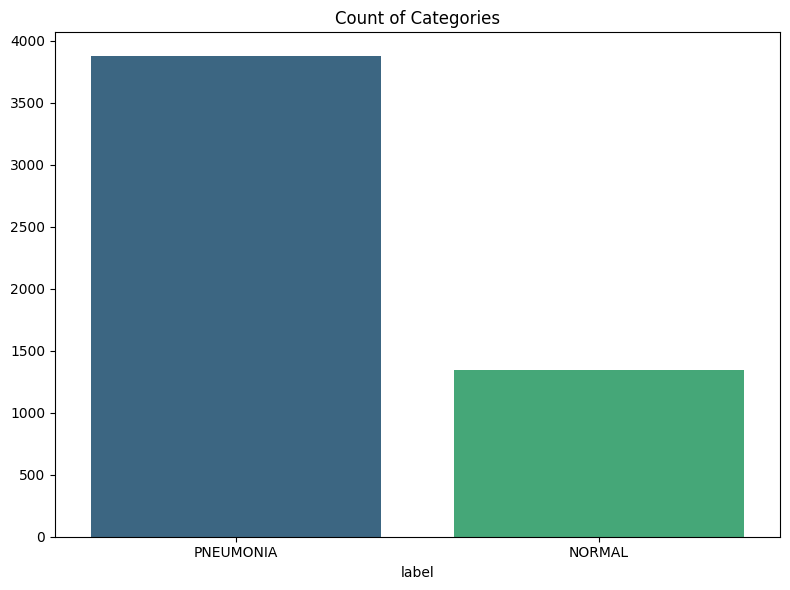

In [16]:
count = df_train['label'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=count.index, y=count.values, palette="viridis")
plt.title('Count of Categories')
plt.tight_layout()
plt.show()

From the graph we can see this dataset is imbalanced dataset because pneumonia is three times the normal


In [17]:
def visualize_images(path, num_images=5):
    image_filenames = os.listdir(path)
    num_images = min(num_images, len(image_filenames))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')
    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)

    plt.tight_layout()
    plt.show()

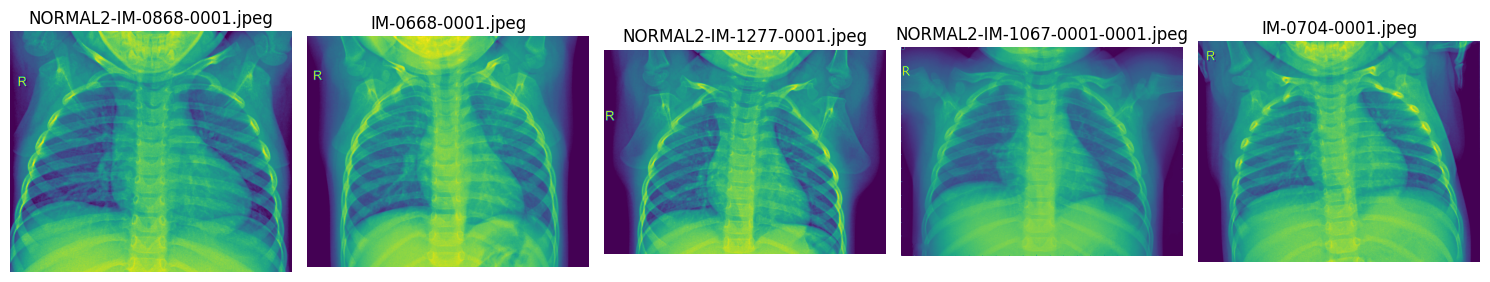

In [18]:
path_to_visualize =   r'/content/chest-xray-pneumonia/chest_xray/train/NORMAL'

visualize_images(path_to_visualize, num_images=5)

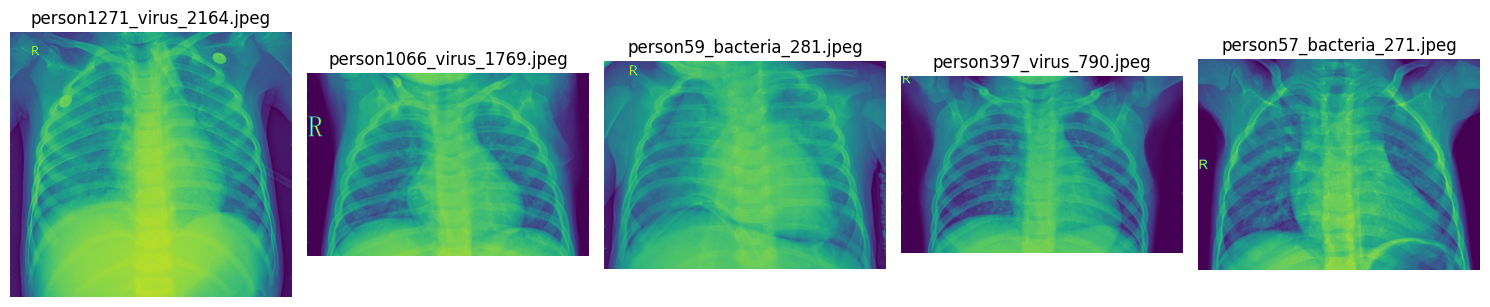

In [19]:
path_to_visualize = r'/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

visualize_images(path_to_visualize, num_images=5)

In [20]:
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dropout(0.45))
model.add(Dense(220, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(60,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds,
                        epochs= 20,
                        validation_data = validation_ds,
                        callbacks = early_stopping)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 91s 407ms/step - accuracy: 0.8914 - loss: 0.2591 - val_accuracy: 0.9520 - val_loss: 0.1723
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.9459 - loss: 0.1408 - val_accuracy: 0.9655 - val_loss: 0.1038
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.9546 - loss: 0.1131 - val_accuracy: 0.9750 - val_loss: 0.0739
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.9607 - loss: 0.1044 - val_accuracy: 0.9693 - val_loss: 0.0851
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 44s 296ms/step - accuracy: 0.9616 - loss: 0.0949 - val_accuracy: 0.9655 - val_loss: 0.0762
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 78s 272ms/step - accuracy: 0.9625 - loss: 0.0894 - val_accuracy: 0.9674 - val_loss: 0.0744
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.9741 - loss: 0.0745 - val_accuracy: 0.9750 - val_loss: 0.0713
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.9757 - loss: 0

In [22]:
validation_loss, validation_accuracy = model.evaluate(validation_ds)
validation_loss

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9741 - loss: 0.0654


0.07129832357168198

In [23]:
validation_accuracy

0.9750480055809021

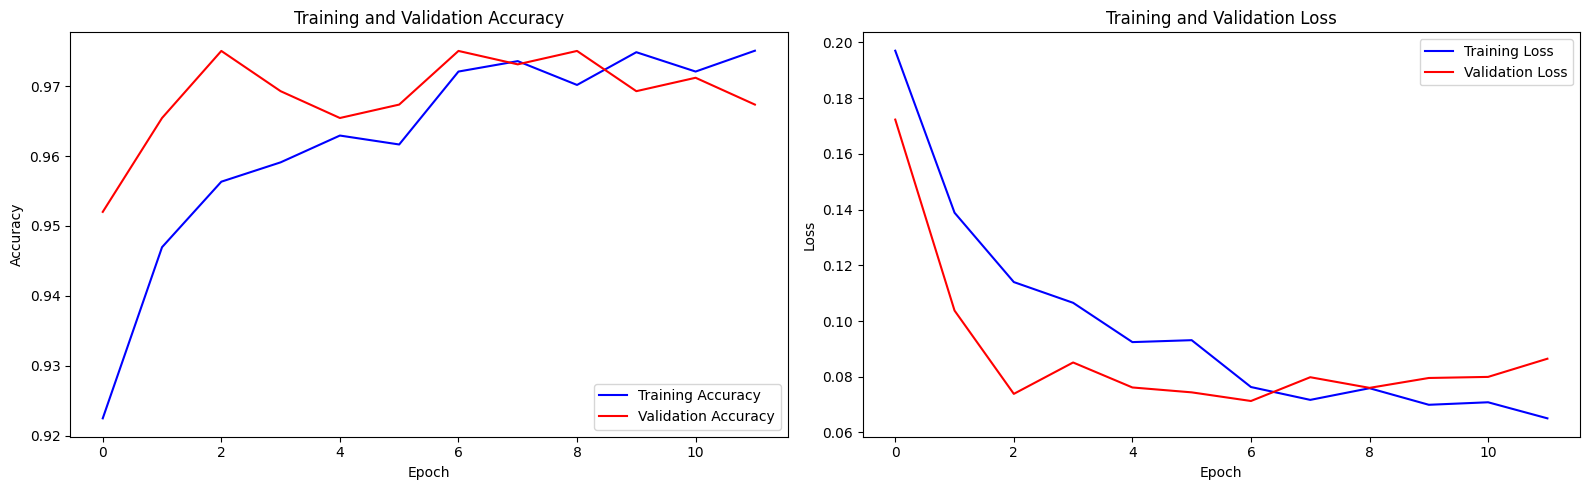

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

From the graph we can see that our best epoch is 6

In [29]:
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    predictions = model.predict(dataset)
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))
    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
      images = images.numpy()
      for j in range(len(images)):
            if i * num_images_per_row + j < num_images:
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]

                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step


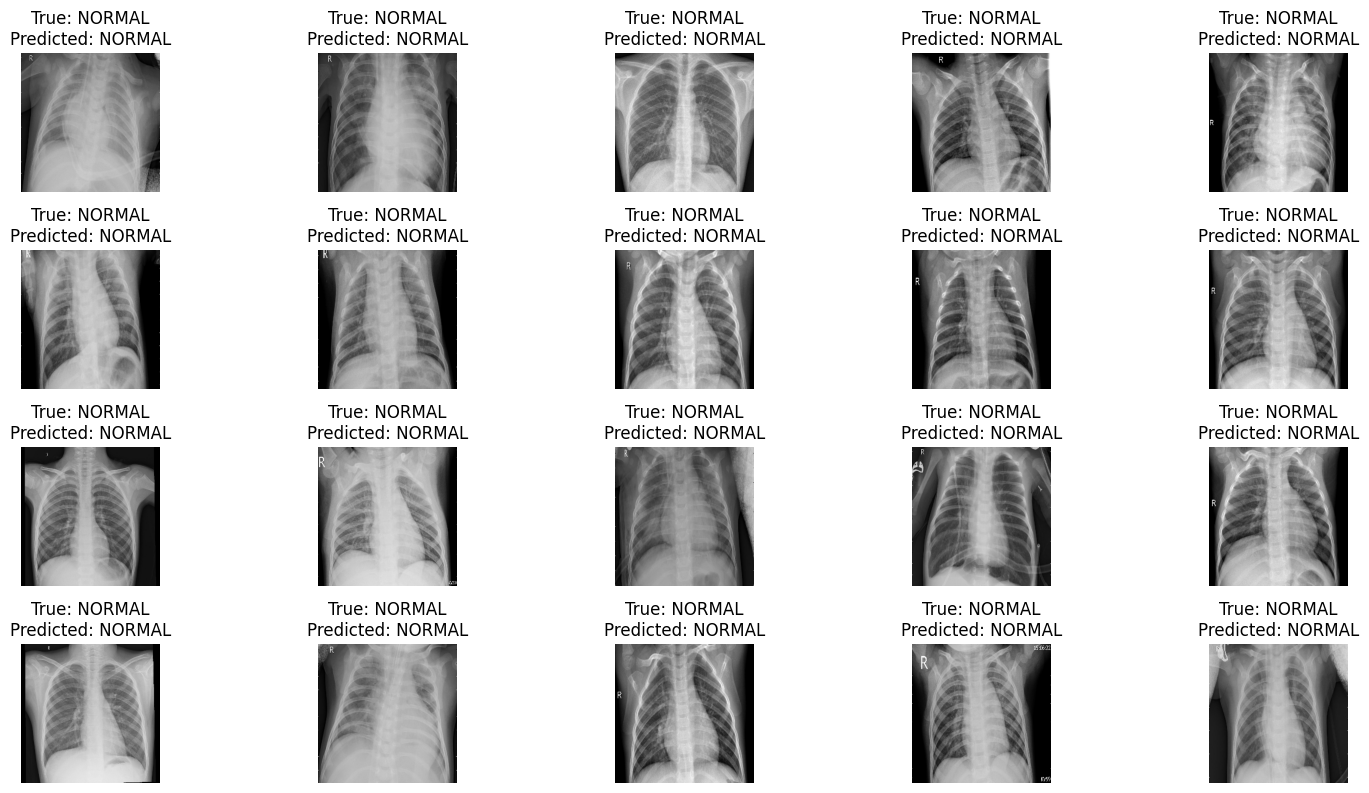

In [30]:
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)